# Final Project

## TRAC2- Transformer Models (BERT) - base uncased

In this section we build a BERT (Bidirectional Encoder Representations from Transformers) model.  

## Package imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from datasets import load_dataset

from sklearn.preprocessing import label_binarize
from sklearn import metrics

## Helper functions

In [5]:
def from_logits_to_labels(pred, task):
    '''
    Returns labels based on predicted logits on labels [CAG,NAG,OAG] for task A. Task B is binary, and 'GEN' represents 
    the positive class.
    Parameters:
    pred: array with model prediction
    task: either 'A' or 'B'
    '''
    index_a = {0:'CAG', 1:'NAG', 2:'OAG'}
    index_b = {0:'NGEN', 1:'GEN'}
    
    if task == 'A':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_a.get)(highest_prob_class.astype(int))
        
    elif task == 'B':
#         labels = np.where(pred <0.5, 'NGEN', 'GEN')
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_b.get)(highest_prob_class.astype(int))
    else:
        labels = []
        
    return labels    

In [6]:
def to_binary_labels(string_labels, classes_list):
    '''
    Returns an array with 0 and 1 for a binary classification problem.
    Parameters:
    string_labels: array with 2 categories defined as strings e.g. ['cat', 'dog', 'dog', ...] 
    classes_list: array with the two classes. The order of the array defines which gets 0 and which gets 1. The first
                  gets 0.
    '''

    labels = label_binarize(string_labels, classes = classes_list).flatten()
    
    return labels 

In [7]:
def to_one_hot_labels(string_labels):
    '''
    Returns one-hot encoded labels from a multi-class label vector e.g. ['cat', 'dog', 'dog', 'lion', 'cat', ...] 
    Parameters:
    string_labels: 
    '''
    labels = pd.get_dummies(string_labels)
    labels = labels.to_numpy()
    
    return labels

In [8]:
# this is modified to get the prediction as parameter
# to avoid predicting again since inference takes time
def confusion_matrix_plot(pred_labels, true_labels, task, normalize=None):
    '''
    Returns a confusion matrix with a nice format.
    Parameters:
    pred_labels: predicted labels
    true_labels: true labels 
    task: 'A' or 'B'
    normalize: if want to normalize the confusion matrix normalize='true'
    '''
    
    # Create a confusion matrix
    cm = metrics.confusion_matrix(true_labels, pred_labels, normalize=normalize)
    cm = np.around(cm, 2)

    # Plot the confusion matrix
    if task == 'A':
        axis_labels = ['CAG', 'NAG', 'OAG']
    elif task == 'B':
        axis_labels = ['GEN', 'NGEN']

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")

    # Create the ticks and labels
    ax.set_xticks(np.arange(len(axis_labels)))
    ax.set_yticks(np.arange(len(axis_labels)))
    ax.set_xticklabels(axis_labels)
    ax.set_yticklabels(axis_labels)

    # Axis titles
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

    # Loop over data dimensions and create text annotations.
    for i in range(len(axis_labels)):
        for j in range(len(axis_labels)):
            text = ax.text(j, i, cm[i, j],ha="center", va="center", color="dimgrey", size=12)
    
    ax.set_title("Confusion Matrix", size=16, weight="bold")
    fig.tight_layout()
    plt.show()


In [9]:
def loss_accuracy_plots(training_history, xrange, task):
    '''
    Returns plots for loss and accuracy during the training process of a NN.
    Parameters:
    training_history: object that stores the training history of the NN (from model.fit(...))
    xrange: range in x axis
    task: string used for the title in the plot
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # loss plot
    ax1.plot(training_history.history['loss'], color='black')
    ax1.plot(training_history.history['val_loss'], color='blue')
    ax1.set_title('Training and validation loss Sub-Task ' + task)
    ax1.legend(['training', 'development'])
    ax1.grid(which='both')
    ax1.set_xticks(np.arange(0, xrange, 2))
    
    # accuracy plot
    if task == 'A':
        ax2.plot(training_history.history['categorical_accuracy'], color='black')
        ax2.plot(training_history.history['val_categorical_accuracy'], color='blue')
        ax2.set_title('Training and validation acccuracy Sub_Task ' + task)
        ax2.legend(['training', 'development'])
        ax2.grid(which='both')
        ax2.set_xticks(np.arange(0, xrange, 2))
    elif task == 'B':
        ax2.plot(training_history.history['sparse_categorical_accuracy'], color='black')
        ax2.plot(training_history.history['val_sparse_categorical_accuracy'], color='blue')
        ax2.set_title('Training and validation acccuracy Sub_Task ' + task)
        ax2.legend(['training', 'development'])
        ax2.grid(which='both')
        ax2.set_xticks(np.arange(0, xrange, 2))
    plt.show()
    

## Load data
Load training, development and test datasets.

In [10]:
# Load labels using pandas dataframes

train_labels_a = pd.read_csv('../../../data/release-files/eng/trac2_eng_train.csv')['Sub-task A']
train_labels_b = pd.read_csv('../../../data/release-files/eng/trac2_eng_train.csv')['Sub-task B']
dev_labels_a = pd.read_csv('../../../data/release-files/eng/trac2_eng_dev.csv')['Sub-task A']
dev_labels_b = pd.read_csv('../../../data/release-files/eng/trac2_eng_dev.csv')['Sub-task B']
test_labels_a = pd.read_csv('../../../data/release-files/gold/trac2_eng_gold_a.csv')['Sub-task A']
test_labels_b = pd.read_csv('../../../data/release-files/gold/trac2_eng_gold_b.csv')['Sub-task B']

In [11]:
# Load text data using Hugging Face datasets
# need to use the split argument even though we are not splitting. If not, data is loaded as DatasetDict
# to load as dataset need to include the split parameter
train_dataset = load_dataset('csv', data_files='../../../data/release-files/eng/trac2_eng_train.csv', split = 'train[:4263]')
dev_dataset = load_dataset('csv', data_files='../../../data/release-files/eng/trac2_eng_dev.csv', split = 'train[:1066]')
test_dataset = load_dataset('csv', data_files='../../../data/release-files/test/trac2_eng_test.csv', split = 'train[:1200]')

Using custom data configuration default-3bcd76a1a4d8b6ec
Reusing dataset csv (/Users/isabel/.cache/huggingface/datasets/csv/default-3bcd76a1a4d8b6ec/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)
Using custom data configuration default-a842edb638833834
Reusing dataset csv (/Users/isabel/.cache/huggingface/datasets/csv/default-a842edb638833834/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)
Using custom data configuration default-bfcd354802845a1d
Reusing dataset csv (/Users/isabel/.cache/huggingface/datasets/csv/default-bfcd354802845a1d/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


## Encode labels

In [12]:
# encode labels Task A- [CAG,NAG,OAG]
train_labels_a_enc = to_one_hot_labels(train_labels_a)
dev_labels_a_enc = to_one_hot_labels(dev_labels_a)
test_labels_a_enc = to_one_hot_labels(test_labels_a)


In [13]:
# encode labels Task B- 0:NGEN, 1:GEN
train_labels_b_enc = to_binary_labels(train_labels_b, classes_list=['NGEN', 'GEN'])
dev_labels_b_enc = to_binary_labels(dev_labels_b, classes_list=['NGEN', 'GEN'])
test_labels_b_enc = to_binary_labels(test_labels_b, classes_list=['NGEN', 'GEN'])

## Prepare TensorFlow datasets for BERT

In [14]:
# remove columns to leave only the column with the posts. Column 'Text'
train_dataset = train_dataset.remove_columns(['ID', 'Sub-task B', 'Sub-task A'])
dev_dataset = dev_dataset.remove_columns(['ID', 'Sub-task A', 'Sub-task B'])
test_dataset = test_dataset.remove_columns('ID')

In [15]:
# define a BERT tokenizer
# use the bert-based-uncased tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [16]:
# test how the tokenizer works
test_sentence = 'I REALLY want to take some vacations soon'
test_sentence

'I REALLY want to take some vacations soon'

In [17]:
encoded_input = tokenizer(test_sentence)
encoded_input

{'input_ids': [101, 1045, 2428, 2215, 2000, 2202, 2070, 10885, 2015, 2574, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
tokenizer.decode(encoded_input['input_ids'])

'[CLS] i really want to take some vacations soon [SEP]'

The tokenizer automatically lowercase the input text, and ads some special tokens ([CLS] and [SEP]) that the BERT model expects.

To use the training examples in the model we need to pad (or truncate) each example to a maximum lenght. For BERT the maximum possible length is 512. 

In [19]:
# tokenize the train, development and test data
# Use a max sequence of 150 tokens. Based on EDA this is enough for majority of posts

train_dataset_tok = train_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)
dev_dataset_tok = dev_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)
test_dataset_tok = test_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)

Loading cached processed dataset at /Users/isabel/.cache/huggingface/datasets/csv/default-3bcd76a1a4d8b6ec/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-f296505d1c4f8e31.arrow
Loading cached processed dataset at /Users/isabel/.cache/huggingface/datasets/csv/default-a842edb638833834/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-c16125cdf10d092e.arrow
Loading cached processed dataset at /Users/isabel/.cache/huggingface/datasets/csv/default-bfcd354802845a1d/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-a0623328f6d09454.arrow


In [20]:
# now we can remove the column with the original post from the dataset. We are going to use the result of tokenization for modeling
train_dataset_tok = train_dataset_tok.remove_columns(['Text']).with_format('tensorflow')
dev_dataset_tok = dev_dataset_tok.remove_columns(['Text']).with_format('tensorflow')
test_dataset_tok = test_dataset_tok.remove_columns(['Text']).with_format('tensorflow')

In [21]:
# extract features from tokenizer output: 'input_ids', 'token_type_ids', 'attention_mask'
train_features = {x: train_dataset_tok[x].to_tensor() for x in tokenizer.model_input_names}
dev_features = {x: dev_dataset_tok[x].to_tensor() for x in tokenizer.model_input_names}
test_features = {x: test_dataset_tok[x].to_tensor() for x in tokenizer.model_input_names}

Metal device set to: Apple M1


2021-10-03 18:01:04.710136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-03 18:01:04.710406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
# finally we create a dataset with features and labels

# Task A
train_tf_dataset_a = tf.data.Dataset.from_tensor_slices((train_features, train_labels_a_enc))
dev_tf_dataset_a = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels_a_enc))
test_tf_dataset_a = tf.data.Dataset.from_tensor_slices((test_features, test_labels_a_enc))

# Task B
train_tf_dataset_b = tf.data.Dataset.from_tensor_slices((train_features, train_labels_b_enc))
dev_tf_dataset_b = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels_b_enc))
test_tf_dataset_b = tf.data.Dataset.from_tensor_slices((test_features, test_labels_b_enc))

In [23]:
# shuffle training data and define batches. Define batches for development and test data.

batch_size = 16

# Task A
train_tf_dataset_a = train_tf_dataset_a.shuffle(len(train_dataset_tok)).batch(batch_size)
dev_tf_dataset_a = dev_tf_dataset_a.batch(batch_size)
test_tf_dataset_a = test_tf_dataset_a.batch(batch_size)

# Task B
train_tf_dataset_b = train_tf_dataset_b.shuffle(len(train_dataset_tok)).batch(batch_size)
dev_tf_dataset_b = dev_tf_dataset_b.batch(batch_size)
test_tf_dataset_b = test_tf_dataset_b.batch(batch_size)

## Model Task A

In [21]:
# delete model if exists
try:
    del BERT_model_A
except:
    pass

In [22]:
# define the model. Task A is a classification task with 3 labels
BERT_model_A = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# compile model
BERT_model_A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics=tf.metrics.CategoricalAccuracy()
                    )

In [24]:
# fit model
training_history = BERT_model_A.fit(train_tf_dataset_a, validation_data=dev_tf_dataset_a, epochs=2)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-10-03 16:57:32.618405: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-03 16:57:32.646702: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-03 16:57:32.648239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


267/267 [==============================] - ETA: 0s - loss: 0.5428 - categorical_accuracy: 0.7962WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-10-03 17:06:38.136559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


267/267 [==============================] - 586s 2s/step - loss: 0.5428 - categorical_accuracy: 0.7962 - val_loss: 0.4799 - val_categorical_accuracy: 0.7983
Epoch 2/2
267/267 [==============================] - 590s 2s/step - loss: 0.3843 - categorical_accuracy: 0.8464 - val_loss: 0.4692 - val_categorical_accuracy: 0.8068


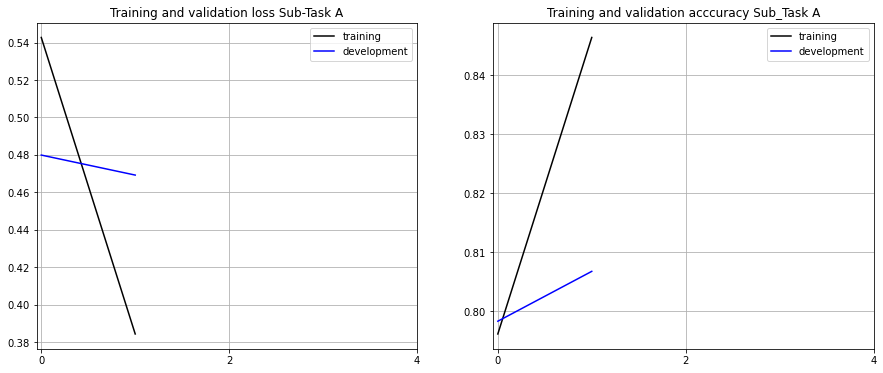

In [25]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=5, task='A')

2021-10-03 17:17:04.355274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


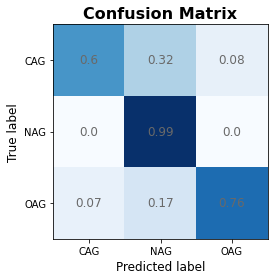

              precision    recall  f1-score   support

         CAG      0.875     0.603     0.714       453
         NAG      0.940     0.994     0.966      3375
         OAG      0.871     0.761     0.812       435

    accuracy                          0.929      4263
   macro avg      0.895     0.786     0.831      4263
weighted avg      0.926     0.929     0.924      4263

Weighted f1-score: 0.9235244561393406


In [26]:
# Evaluate model on TRAINING data

# predict using model. Returns logits
pred_labels_train = BERT_model_A.predict(train_features)[0]

# convert logits lo labels
pred_labels_train = from_logits_to_labels(pred_labels_train, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_train, train_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_a, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_a, pred_labels_train, pos_label=1, average='weighted')}")


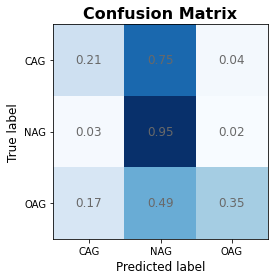

              precision    recall  f1-score   support

         CAG      0.369     0.205     0.264       117
         NAG      0.848     0.953     0.898       836
         OAG      0.639     0.345     0.448       113

    accuracy                          0.807      1066
   macro avg      0.619     0.501     0.537      1066
weighted avg      0.773     0.807     0.780      1066

Weighted f1-score: 0.7803387843337382


In [27]:
# Evaluate model on DEVELOPMENT data

# predict using model. Returns logits
pred_labels_dev = BERT_model_A.predict(dev_features)[0]

# convert logits lo labels
pred_labels_dev = from_logits_to_labels(pred_labels_dev, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_dev, dev_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_a, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_a, pred_labels_dev, pos_label=1, average='weighted')}")

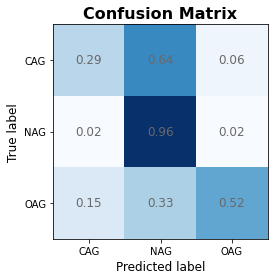

              precision    recall  f1-score   support

         CAG      0.532     0.295     0.379       224
         NAG      0.735     0.962     0.834       690
         OAG      0.855     0.517     0.645       286

    accuracy                          0.732      1200
   macro avg      0.708     0.591     0.619      1200
weighted avg      0.726     0.732     0.704      1200

Weighted f1-score: 0.7038481829946517


In [28]:
# Evaluate model on TEST data

# predict using model. Returns logits
pred_labels_test = BERT_model_A.predict(test_features)[0]

# convert logits lo labels
pred_labels_test = from_logits_to_labels(pred_labels_test, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_test, test_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_a, pred_labels_test, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_a, pred_labels_test, pos_label=1, average='weighted')}")

In [29]:
# save model
BERT_model_A.save_pretrained('TRAC-2_BERT_model_A')

## Model Task B

In [24]:
# delete model if exists
try:
    del BERT_model_B
except:
    pass

In [25]:
# define the model. Task B is a classification task with 2 labels
BERT_model_B = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# compile model
BERT_model_B.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=tf.metrics.SparseCategoricalAccuracy()
                    )

In [27]:
# fit model
training_history = BERT_model_B.fit(train_tf_dataset_b, validation_data=dev_tf_dataset_b, epochs=3)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-10-03 18:01:36.034972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-03 18:01:36.063380: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-03 18:01:36.064854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


267/267 [==============================] - ETA: 0s - loss: 0.2163 - sparse_categorical_accuracy: 0.9329WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-10-03 18:10:19.445866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


267/267 [==============================] - 563s 2s/step - loss: 0.2163 - sparse_categorical_accuracy: 0.9329 - val_loss: 0.1849 - val_sparse_categorical_accuracy: 0.9362
Epoch 2/3
267/267 [==============================] - 563s 2s/step - loss: 0.1377 - sparse_categorical_accuracy: 0.9514 - val_loss: 0.1757 - val_sparse_categorical_accuracy: 0.9315
Epoch 3/3
267/267 [==============================] - 574s 2s/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.1979 - val_sparse_categorical_accuracy: 0.9512


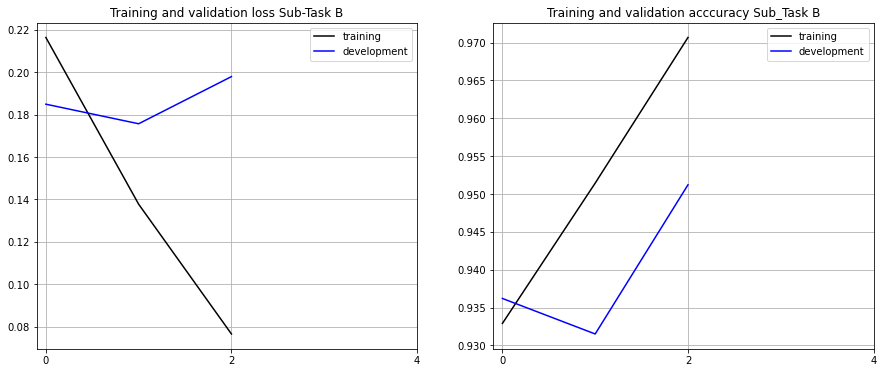

In [28]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=5, task='B')

2021-10-03 18:29:52.435585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


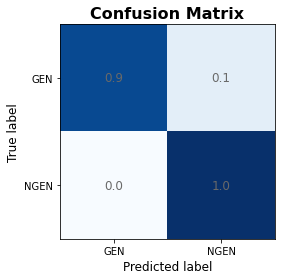

              precision    recall  f1-score   support

         GEN      0.962     0.900     0.930       309
        NGEN      0.992     0.997     0.995      3954

    accuracy                          0.990      4263
   macro avg      0.977     0.948     0.962      4263
weighted avg      0.990     0.990     0.990      4263

Weighted f1-score: 0.9899954575777613


In [29]:
# Evaluate model on TRAINING data

# predict using model. Returns logits
pred_labels_train = BERT_model_B.predict(train_features)[0]

# convert logits lo labels
pred_labels_train = from_logits_to_labels(pred_labels_train, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_train, train_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_b, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_b, pred_labels_train, pos_label=1, average='weighted')}")


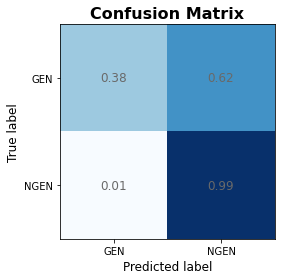

              precision    recall  f1-score   support

         GEN      0.800     0.384     0.519        73
        NGEN      0.956     0.993     0.974       993

    accuracy                          0.951      1066
   macro avg      0.878     0.688     0.746      1066
weighted avg      0.946     0.951     0.943      1066

Weighted f1-score: 0.9430956793098891


In [30]:
# Evaluate model on DEVELOPMENT data

# predict using model. Returns logits
pred_labels_dev = BERT_model_B.predict(dev_features)[0]

# convert logits lo labels
pred_labels_dev = from_logits_to_labels(pred_labels_dev, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_dev, dev_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_b, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_b, pred_labels_dev, pos_label=1, average='weighted')}")

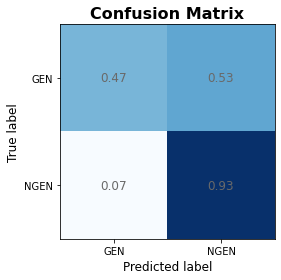

              precision    recall  f1-score   support

         GEN      0.546     0.474     0.508       175
        NGEN      0.912     0.933     0.922      1025

    accuracy                          0.866      1200
   macro avg      0.729     0.703     0.715      1200
weighted avg      0.859     0.866     0.862      1200

Weighted f1-score: 0.861859225427847


In [31]:
# Evaluate model on TEST data

# predict using model. Returns logits
pred_labels_test = BERT_model_B.predict(test_features)[0]

# convert logits lo labels
pred_labels_test = from_logits_to_labels(pred_labels_test, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_test, test_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_b, pred_labels_test, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_b, pred_labels_test, pos_label=1, average='weighted')}")

In [32]:
# save model
BERT_model_B.save_pretrained('TRAC-2_BERT_model_B')

## References

- Pre-processing data: https://huggingface.co/transformers/preprocessing.html

- Fine-tunning a pre-trained model: https://huggingface.co/transformers/training.html

- BERT: https://huggingface.co/transformers/model_doc/bert.html
